<a href="https://colab.research.google.com/github/VoyagerWSH/breaking_bad_cancer/blob/main/Breaking_Bad_Cancer_(demo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/VoyagerWSH/breaking_bad_cancer.git
!pip install lightning
!pip install lifelines
!pip install wandb

sys.path.append('./breaking_bad_cancer')
sys.path.append('./breaking_bad_cancer/src')

# import archetecture and download checkpoint
import models
!gdown 1sJZo97dw2LSa5wemTntaBwpPGqH8eIjW

Cloning into 'breaking_bad_cancer'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 6), reused 15 (delta 1), pack-reused 0
Receiving objects: 100% (27/27), 680.95 KiB | 9.20 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Downloading...
From: https://drive.google.com/uc?id=1sJZo97dw2LSa5wemTntaBwpPGqH8eIjW
To: /content/best_attn_model.ckpt
100% 399M/399M [00:06<00:00, 63.3MB/s]


In [ ]:
# loading the model
attn_resnet = models.Attn_Guided_Resnet()
checkpoint = torch.load('best_attn_model.ckpt', map_location=torch.device('cpu'))
attn_resnet.load_state_dict(checkpoint['state_dict'])
print('Model loaded.')

Model loaded.


In [ ]:
# loading can example cancer image
!gdown 1l4d-sV3XRvcAmzSNB-T-8yvaIhqvXUit
img_normalized = torch.load("cancer_ct_a_normalized.pt", map_location=torch.device('cpu'))
img = (img_normalized*87.1849+128.1722).squeeze()

# loading corresponding ground truth mask
!gdown 14VJ-xCrA76AcXqF4yDp1Zts3S92Kyq1R
true_mask = torch.load("true_mask_a.pt", map_location=torch.device('cpu')).squeeze()


Downloading...
From: https://drive.google.com/uc?id=1l4d-sV3XRvcAmzSNB-T-8yvaIhqvXUit
To: /content/cancer_ct_a_normalized.pt
100% 315M/315M [00:02<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=14VJ-xCrA76AcXqF4yDp1Zts3S92Kyq1R
To: /content/true_mask_a.pt
100% 315M/315M [00:04<00:00, 67.4MB/s]


In [ ]:
attn_resnet.eval()
with torch.no_grad():
  pred, attn_map = attn_resnet.forward(img_normalized.unsqueeze(0))

In [ ]:
# upsample the attention map from latent space to image space for visualization
upsampler = torch.nn.Upsample(size=(200, 256, 256))
pred_attn_mask = upsampler(attn_map).squeeze()

In [ ]:
# for visualization
# find the depth dim with the largest cancer area according to the true mask
d = torch.argmax(true_mask.sum(dim=(1,2)))

Text(0.5, 1.0, 'Ground Truth Localization')

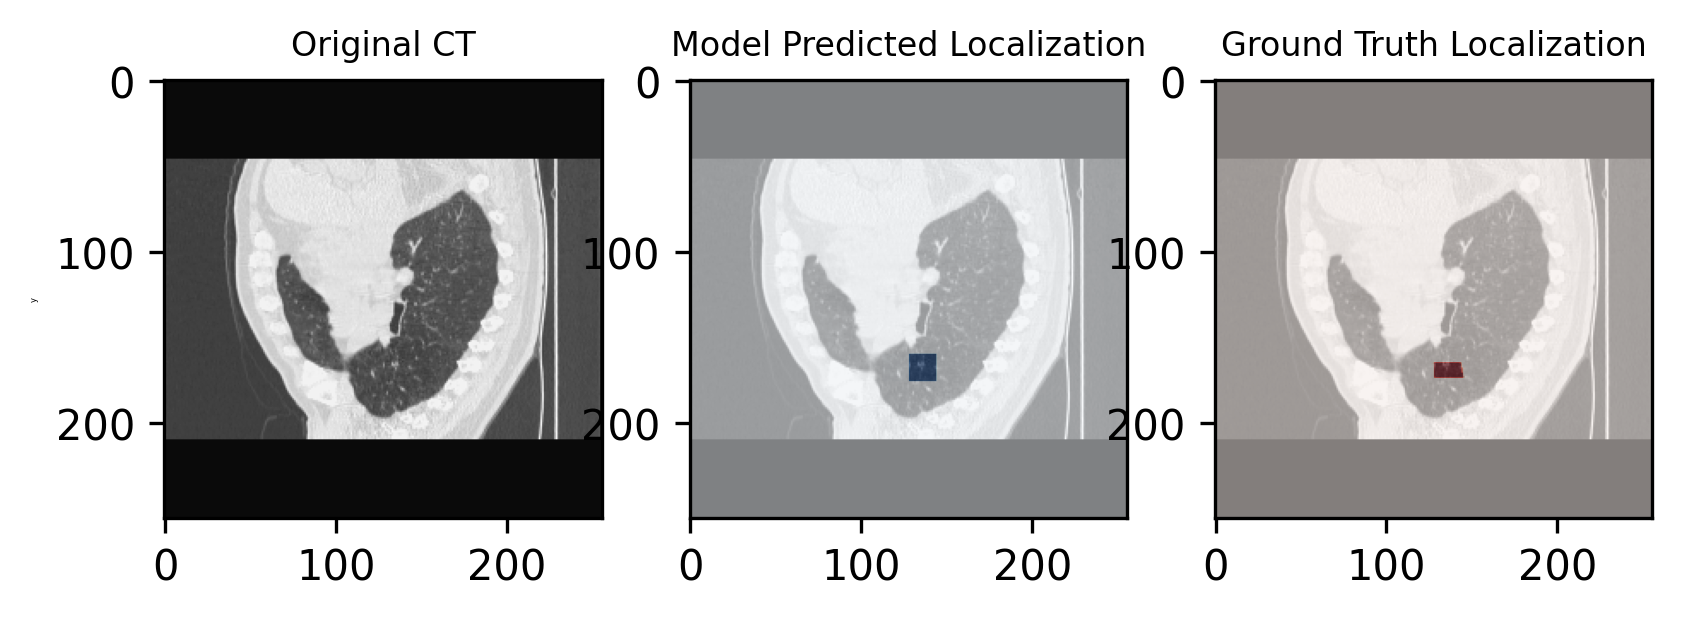

In [ ]:
# plot the visualizations
plt.figure(dpi=300)

plt.subplot(1, 3, 1)
plt.imshow(img[d], cmap='gray')
plt.gca().set_title("Original CT", fontsize=8)
plt.gca().set_ylabel('y', fontsize=2)

plt.subplot(1, 3, 2)
plt.imshow(img[d], cmap='gray')
plt.imshow(pred_attn_mask[d], cmap= 'Blues', alpha=0.5)
plt.gca().set_title("Model Predicted Localization", fontsize=8)

plt.subplot(1, 3, 3)
plt.imshow(img[d], cmap='gray')
plt.imshow(true_mask[d], cmap='Reds', alpha=0.5)
plt.gca().set_title("Ground Truth Localization", fontsize=8)